In [1]:
## My model
import QKLSTM
import Model
import QAOA
## basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## random
import random
import math
from typing import List, Callable, Tuple
## ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import minimize
## QML
import pennylane as qml
from pennylane import qaoa
import networkx as nx
## access file
import os

torch.manual_seed(42)
np.random.seed(42)
qml.math.random.seed(42)
random.seed(42)

In [164]:
import importlib
import QKLSTM 
importlib.reload(QKLSTM)
import Model 
importlib.reload(Model)

<module 'Model' from '/Users/yezhihai/Desktop/QK-QAOA/Model.py'>

## Define Model

In [2]:
"""
Define model and train
"""
# --- Model Training ---
def build_and_train_model(model_type,
                          mapping_type,
                          layers, 
                          input_feature_dim,
                          max_total_params,
                          loss_function_type,
                          qaoa_layers,
                          lr_lstm,
                          lr_mapping,
                          epochs, 
                          steps_recurrent_loop_train,
                          conv_tol_lstm,
                          Model_save_path,
                          train_set,
                          val_set,
                          time_out,
                          continue_train,
                          load_path):
    
    model = Model.LSTM(model_type = model_type,
                      mapping_type= mapping_type,
                      layers = layers,
                       input_feature_dim = input_feature_dim,
                       max_total_params = max_total_params,
                       loss_function_type = loss_function_type,
                        )
    
    if continue_train == True:
        state_dict = torch.load(load_path)
        model.load_state_dict(state_dict)
        print("load params successful!")
    
    print(f"--- Model Summary ---")
    print(model)
    lstm_params = sum(p.numel() for p in model.lstm.parameters())
    print(f"  {model_type} Parameters: {lstm_params}")
    if mapping_type == "DS":
        single_params = sum(p.numel() for p in model.single_mapping.parameters())
        print(f"  Single Mapping Parameters: {single_params}")
        double_params = sum(p.numel() for p in model.double_mapping.parameters())
        print(f"  Double Mapping Parameters: {double_params}")
    else:
        mapping_params = sum(p.numel() for p in model.mapping.parameters())
        print(f"  Mapping Parameters: {mapping_params}")

    trainer = Model.ModelTrain(model = model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = lr_lstm,
                               lr_mapping= lr_mapping,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )
    
    print(f"\n--- Training {model_type} Model ---")

    trainer.train(train_data = train_set,
                  val_data = val_set,
                  epochs = epochs,
                  conv_tol_lstm = conv_tol_lstm,
                  time_out = time_out)
    

    torch.save(model.state_dict(), f"{Model_save_path}_{model_type}_{loss_function_type}.pth")
    print("2D Model saved successfully!")
    
    return model, trainer


## Train Data

In [96]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
train_set = generate_graphs(n_graphs, n_nodes, p_edge)

the size of training set is 120


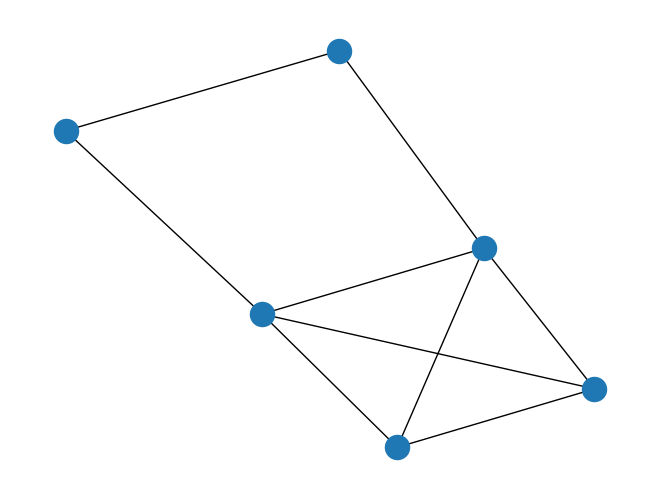

In [39]:
train_set = []
for i in range(6,10): #4
    for j in range(3,9):#6
        for _ in range(5):
            random_graph = nx.gnp_random_graph(n = i, p=j/i, seed = 42)
            train_set.append(random_graph)
nx.draw(train_set[0])
print(f"the size of training set is {len(train_set)}")

the size of training set is 5


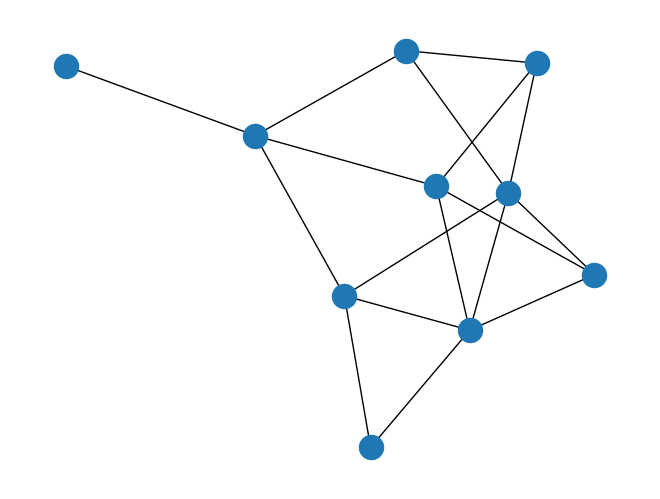

In [6]:
val_set = []

for j in range(3,8):#6
    random_graph = nx.gnp_random_graph(n = 10, p=j/10, seed = 42)
    val_set.append(random_graph)
nx.draw(val_set[0])
print(f"the size of training set is {len(val_set)}")

## Define and Model Train

In [137]:
layers = 1 #LSTM
mapping_type = "ID"
input_feature_dim = 2#layer*qaoa_layers*2
max_total_params = 2   
loss_function_type = "weighted" # observed improvement or weighted
qaoa_layers = 1
epochs = 20 #1000
steps_recurrent_loop_train = 10
steps_recurrent_loop_test = 10
conv_tol_lstm = 1e-4
Results_save_path = "model_result_2D"
Model_save_path = "model_params_2D_continue"
time_out = 2*60*60

lr_qaoa = 0.001
max_iter_qaoa = 300
conv_tol_qaoa = 1e-6
qaoa_optimizer = "SGD"

### LSTM

In [100]:
lstm_model, lstm_trainer = build_and_train_model(
    model_type = "LSTM",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 1e-2, #1e-4
    lr_mapping = 0.01,
    epochs = epochs, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= False,
    load_path = None
    )

--- Model Summary ---
LSTM(
  (lstm): LSTM(3, 2, batch_first=True)
  (mapping): Identity()
)
  LSTM Parameters: 56
  Mapping Parameters: 0

--- Training LSTM Model ---

--- Starting LSTM Model Training ---
Epoch 1/20
Epoch 1 Mean loss: 1.31898803, Mean val loss:8.73521459
Current learning rate: 0.0100000000
Epoch 2/20
Epoch 2 Mean loss: 1.21768149, Mean val loss:8.61168755
Current learning rate: 0.0100000000
Epoch 3/20
Epoch 3 Mean loss: 1.21179721, Mean val loss:8.46418503
Current learning rate: 0.0100000000
Epoch 4/20
Epoch 4 Mean loss: 1.20365775, Mean val loss:8.34858755
Current learning rate: 0.0100000000
Epoch 5/20
Epoch 5 Mean loss: 1.19788280, Mean val loss:8.26525465
Current learning rate: 0.0100000000
Epoch 6/20
Epoch 6 Mean loss: 1.19448819, Mean val loss:8.15243742
Current learning rate: 0.0100000000
Epoch 7/20
Epoch 7 Mean loss: 1.19116056, Mean val loss:8.05222814
Current learning rate: 0.0100000000
Epoch 8/20
Epoch 8 Mean loss: 1.18877446, Mean val loss:7.94971604
Curren

In [101]:
lstm_model = Model.LSTM(model_type = "LSTM",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_LSTM_model.pth")
lstm_model.load_state_dict(state_dict)
lstm_trainer = Model.ModelTrain(model = lstm_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 1e-4,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

### QK

In [167]:
qk_model, qk_trainer = build_and_train_model(
    model_type = "QK",
    mapping_type = mapping_type,
    layers = 1, 
    input_feature_dim = input_feature_dim,
    max_total_params = max_total_params,
    loss_function_type = "weighted",
    qaoa_layers = qaoa_layers,
    lr_lstm = 1e-4,#4e-5, #8e-5,
    lr_mapping = 0.01,
    epochs = 30, 
    steps_recurrent_loop_train = steps_recurrent_loop_train,
    conv_tol_lstm = conv_tol_lstm,
    Model_save_path = Model_save_path,
    train_set = train_set,
    val_set= val_set,
    time_out = time_out,
    continue_train= True,
    load_path = "best_QK_model.pth")

load params successful!
--- Model Summary ---
LSTM(
  (lstm): QKLSTM(
    (clayer_in): Linear(in_features=6, out_features=4, bias=True)
    (clayer_out): Linear(in_features=4, out_features=3, bias=True)
  )
  (mapping): Identity()
)
  QK Parameters: 43
  Mapping Parameters: 0

--- Training QK Model ---

--- Starting QK Model Training ---
Epoch 1/30
Epoch 1 Mean loss: 1.44724393, Mean val loss:7.96290571
Current learning rate: 0.0001000000
Epoch 2/30
Epoch 2 Mean loss: 1.42636354, Mean val loss:7.89904040
Current learning rate: 0.0001000000
Epoch 3/30
Epoch 3 Mean loss: 1.40652004, Mean val loss:7.84101422
Current learning rate: 0.0001000000
Epoch 4/30
Epoch 4 Mean loss: 1.38786659, Mean val loss:7.78913835
Current learning rate: 0.0001000000
Epoch 5/30
Epoch 5 Mean loss: 1.37047860, Mean val loss:7.74338357
Current learning rate: 0.0001000000
Epoch 6/30
Epoch 6 Mean loss: 1.35437320, Mean val loss:7.70356161
Current learning rate: 0.0001000000
Epoch 7/30
Epoch 7 Mean loss: 1.33953711, 

In [170]:
qk_model = Model.LSTM(model_type = "QK",
                    mapping_type= mapping_type,
                    layers = layers,
                    input_feature_dim = input_feature_dim,
                    max_total_params = max_total_params,
                    loss_function_type = loss_function_type,
                        )
state_dict = torch.load("best_QK_model.pth")
qk_model.load_state_dict(state_dict)
qk_trainer = Model.ModelTrain(model = qk_model,
                               qaoa_layers = qaoa_layers,
                               lr_lstm = 8e-5,
                               lr_mapping= 0.01,
                               num_rnn_iteration = steps_recurrent_loop_train,
                               )

## Evaluate

In [174]:
test_set = []

j = 4 #3~8  
node = 12

for j in range(3,8):
    random_graph = nx.gnp_random_graph(n = node, p=j/node, seed = 42)
    #random_graph = nx.gnp_random_graph(7, p=3 / 7)
    test_set.append(random_graph)
print(len(test_set))

5


In [158]:
test_set = []
new_graph = nx.gnp_random_graph(7, p=3 / 7)
test_set.append(new_graph)
new_graph_2 = nx.gnp_random_graph(8, p=3 / 8)
test_set.append(new_graph_2)


--- Evaluating Model ---

--- Starting LSTM Model Testing ---
LSTM predicted energies:[6.082175068525066, 6.1167906294501355, 6.144518390126988, 6.135292195721292, 6.136695226790213, 6.136393643267244, 6.136455034815508, 6.13644377080566, 6.136446230021702, 6.136445745521889]
LSTM predicted params:tensor([0.5178, 0.4790])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---


/Users/yezhihai/Desktop/QK-QAOA/QAOA.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad=True, dtype=torch.float32)


Step = 50/300, Energy = 6.03421684 Ha
Step = 100/300, Energy = 6.03198385 Ha
  Convergence reached at step 134
Optimization finished, final energy: 6.03188453 Ha

--- Starting QK Model Testing ---
QK predicted energies:[8.243030645431476, 6.905283281008907, 6.51235110122285, 6.434816692163709, 6.439052843829465, 6.45947596728667, 6.479097010018876, 6.494413243168155, 6.5055296553620705, 6.513338509090536]
QK predicted params:tensor([0.4822, 0.5471])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 6.03881898 Ha
Step = 100/300, Energy = 6.03216309 Ha
Step = 150/300, Energy = 6.03188452 Ha
  Convergence reached at step 150
Optimization finished, final energy: 6.03188452 Ha

--- Standard QAOA, SGD params ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 9.82154412 Ha
Step = 100/300, Energy = 7.23511875 Ha
Step = 150/300, Energy = 6.08714980 Ha
Step = 200/300, Energy = 6.03464956 Ha
Step = 250/300, Energy = 6.03202034 Ha
  Conve

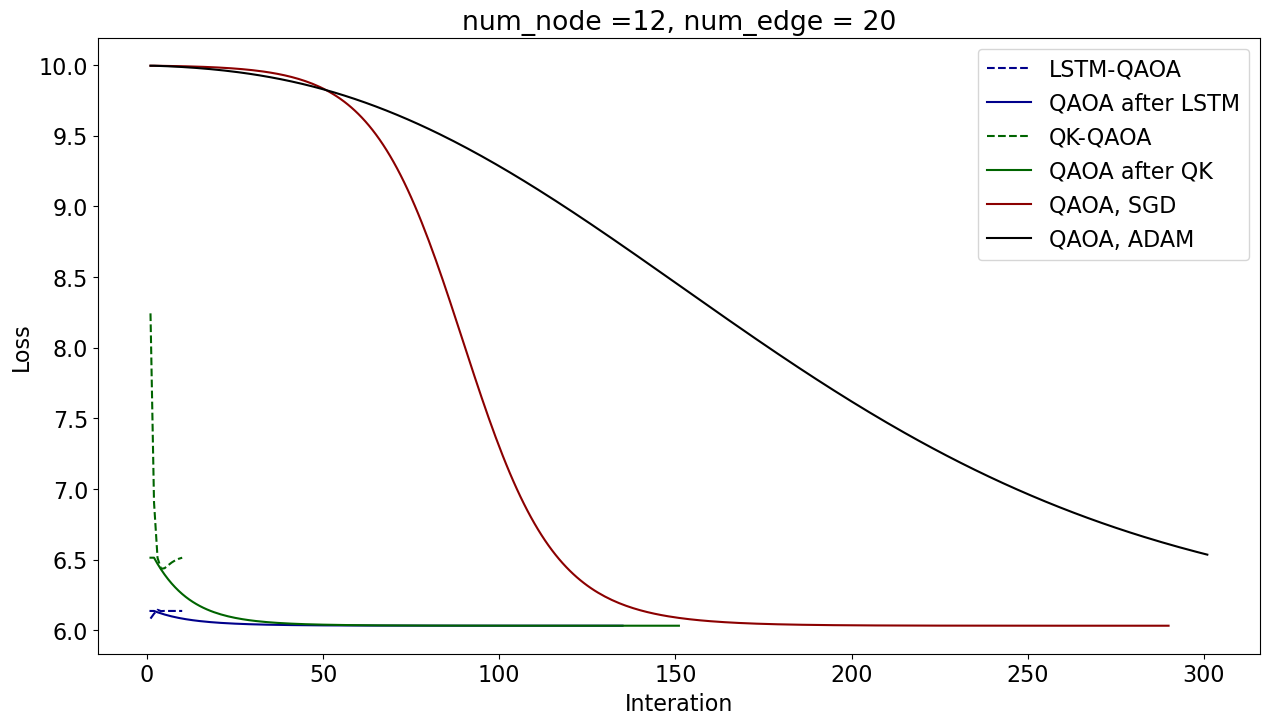

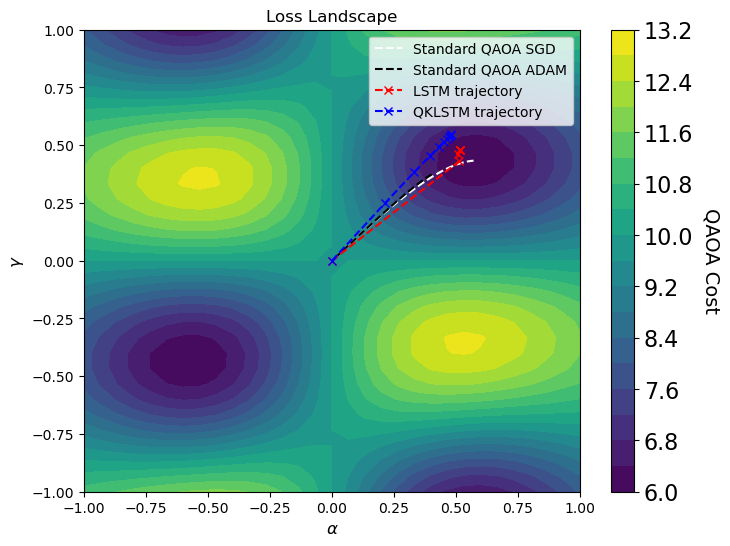


--- Starting LSTM Model Testing ---
LSTM predicted energies:[7.280395400032068, 7.324483412879146, 7.3504340658281855, 7.336622913330938, 7.337913126499767, 7.337533847491112, 7.33758700283899, 7.337574861414913, 7.337576798810093, 7.337576241822091]
LSTM predicted params:tensor([0.4806, 0.4886])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.26094180 Ha
  Convergence reached at step 91
Optimization finished, final energy: 7.26048718 Ha

--- Starting QK Model Testing ---
QK predicted energies:[9.857328650999237, 8.157832751529234, 7.624729851600896, 7.50086502429594, 7.490193171300235, 7.5060125363126176, 7.524404628395731, 7.539551612833994, 7.550783695863985, 7.558745633333392]
QK predicted params:tensor([0.4822, 0.5471])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 7.26128028 Ha
  Convergence reached at step 91
Optimization finished, final energy: 7.26048576 Ha

--- Standard QA

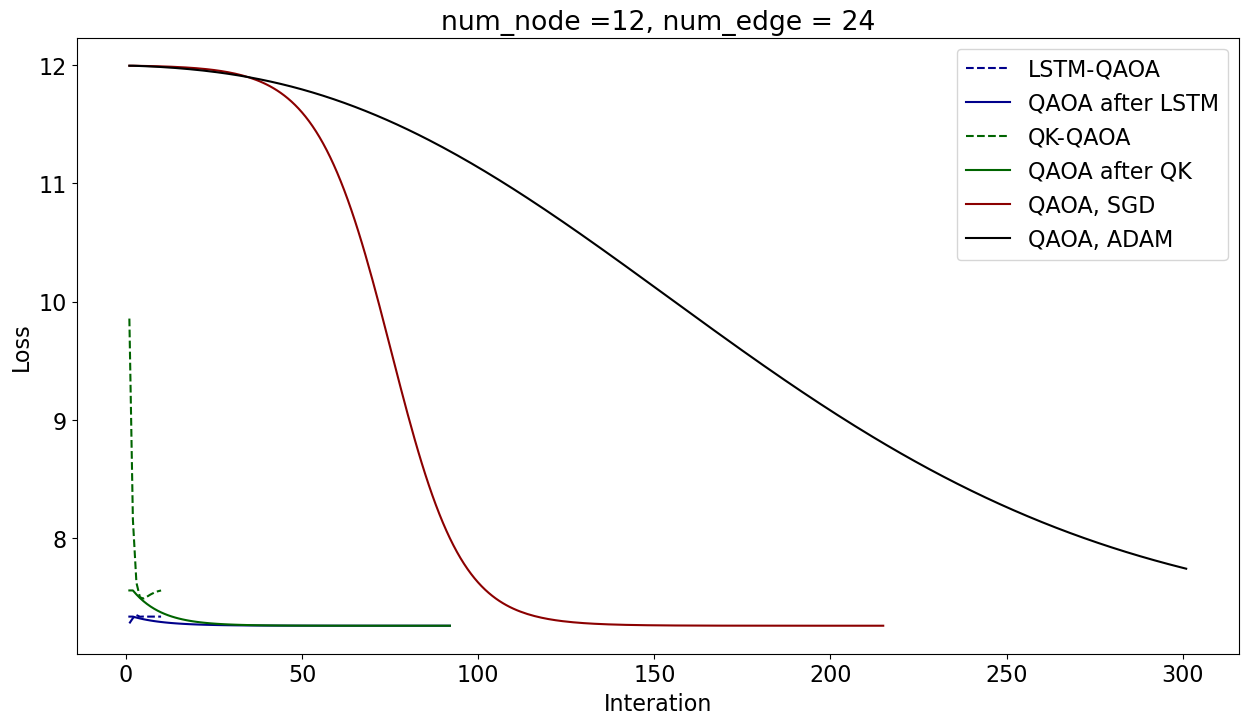

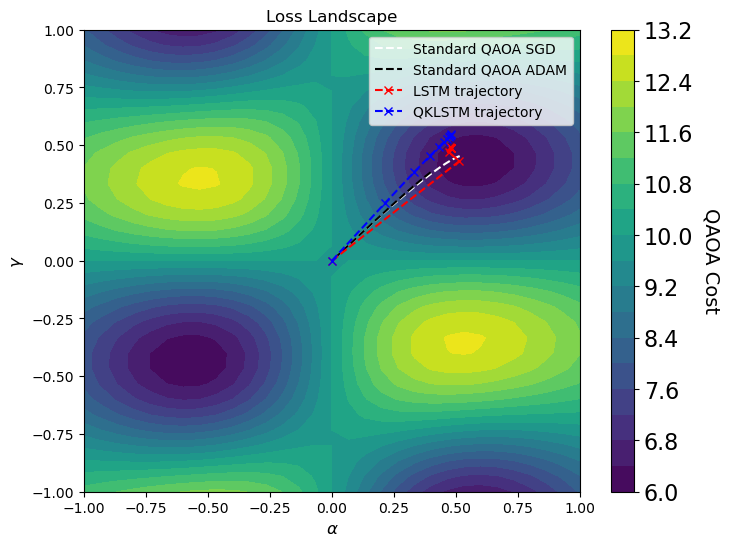


--- Starting LSTM Model Testing ---
LSTM predicted energies:[9.618397358701593, 9.632201448171578, 9.687341985391166, 9.653867197035048, 9.655797106908096, 9.654657477505353, 9.654777506084812, 9.654737425793423, 9.65474355163011, 9.654742124159503]
LSTM predicted params:tensor([0.4124, 0.5069])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 9.49947149 Ha
  Convergence reached at step 71
Optimization finished, final energy: 9.49935027 Ha

--- Starting QK Model Testing ---
QK predicted energies:[12.320550150127158, 10.246136115685328, 9.65816575757211, 9.56294930034145, 9.587655922470677, 9.630802038041878, 9.668108349973899, 9.695853974685505, 9.715345210818606, 9.728681648852762]
QK predicted params:tensor([0.4822, 0.5471])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 9.49961645 Ha
  Convergence reached at step 77
Optimization finished, final energy: 9.49935064 Ha

--- Standard QAO

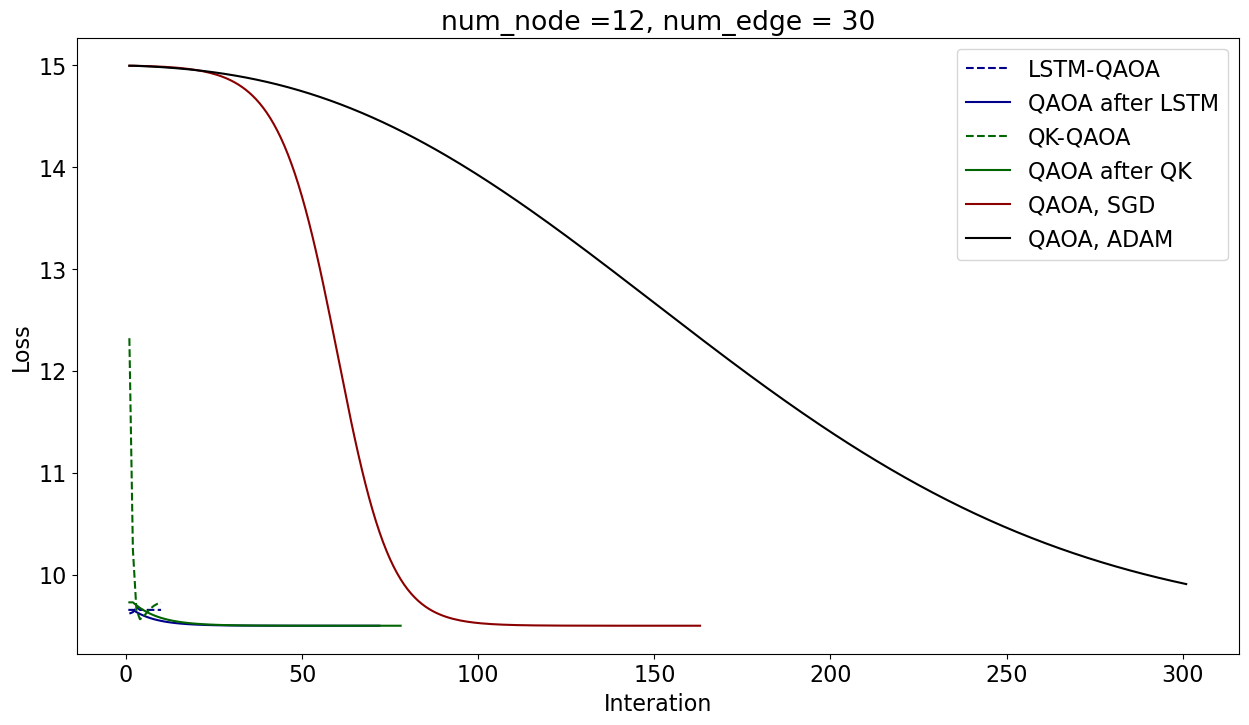

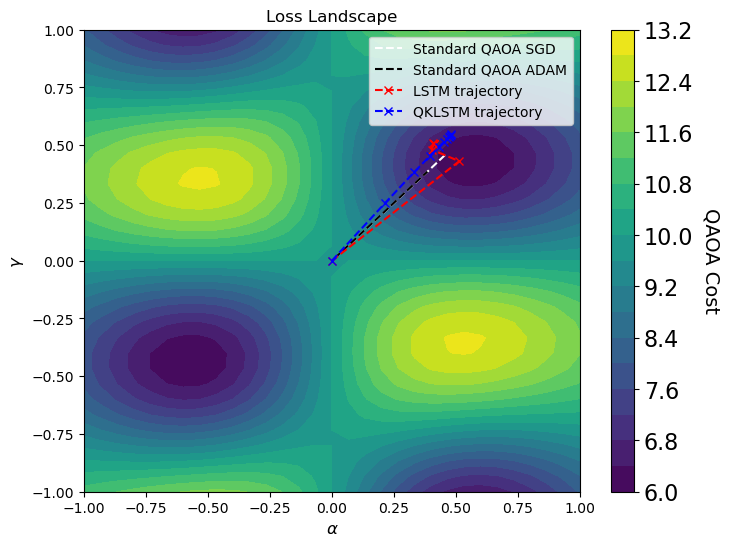


--- Starting LSTM Model Testing ---
LSTM predicted energies:[9.918218435408034, 9.933437004241144, 9.987611350758662, 9.949106519858388, 9.950411294516842, 9.949016098913251, 9.94911780383335, 9.949069344913363, 9.949075054449679, 9.949073324990124]
LSTM predicted params:tensor([0.4039, 0.5092])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 9.76958108 Ha
  Convergence reached at step 69
Optimization finished, final energy: 9.76948930 Ha

--- Starting QK Model Testing ---
QK predicted energies:[12.720525527925767, 10.55034260358268, 9.926804729163925, 9.82069108077229, 9.842287396765778, 9.884690633222288, 9.921942268754028, 9.94979941172191, 9.969412937312551, 9.982844250748832]
QK predicted params:tensor([0.4822, 0.5471])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 9.76969838 Ha
  Convergence reached at step 75
Optimization finished, final energy: 9.76949014 Ha

--- Standard QAOA

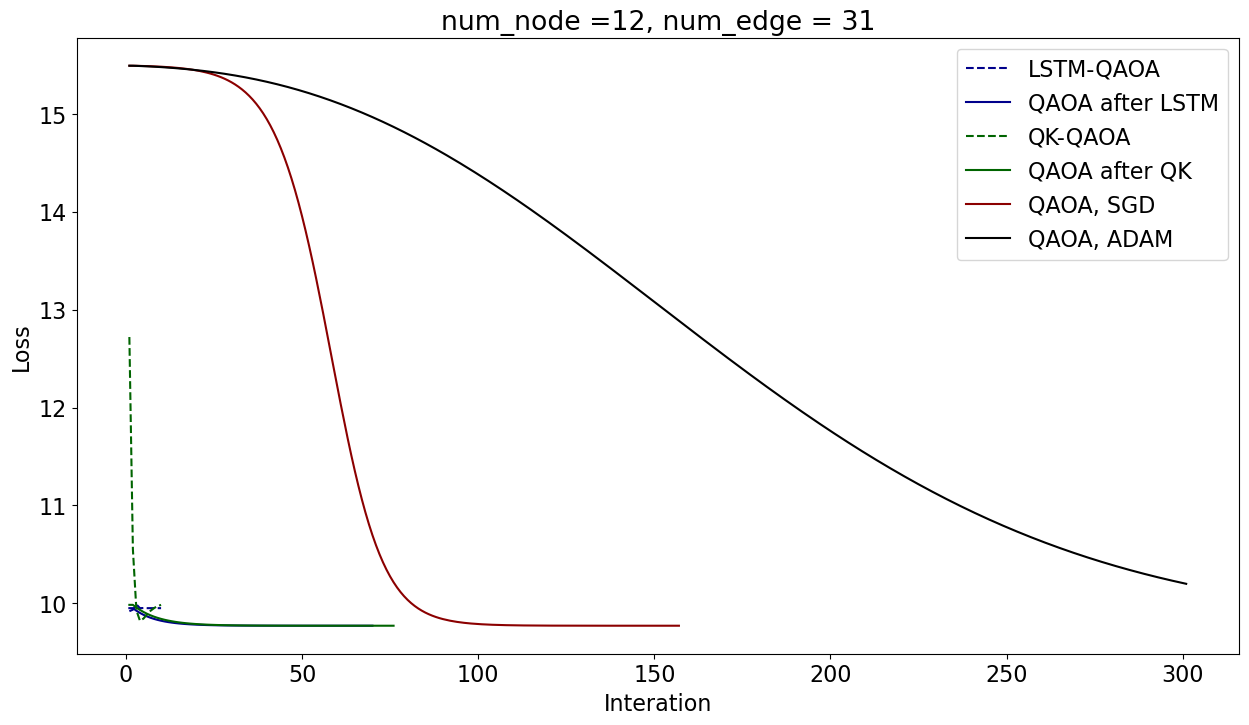

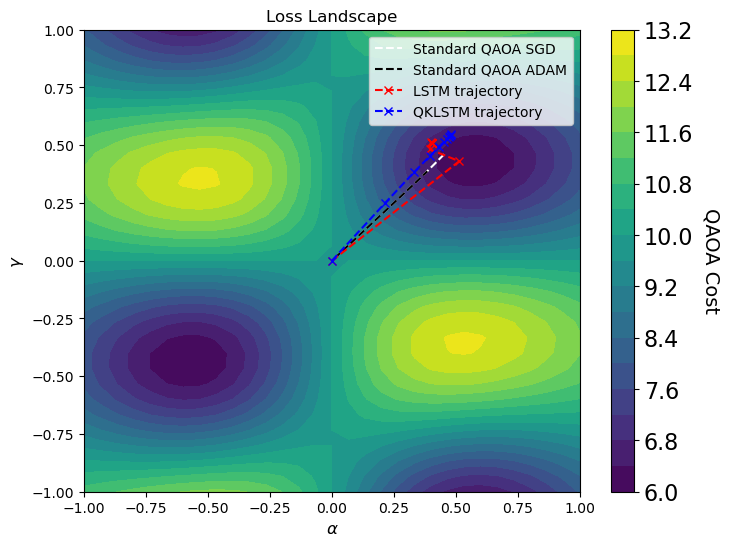


--- Starting LSTM Model Testing ---
LSTM predicted energies:[12.127473567088, 12.192349812470365, 12.298002435819665, 12.220827007780464, 12.214033895383404, 12.207560943206119, 12.20649110260568, 12.205969072377728, 12.20585615883973, 12.205813250064562]
LSTM predicted params:tensor([0.3390, 0.5267])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 11.68015055 Ha
  Convergence reached at step 57
Optimization finished, final energy: 11.68013828 Ha

--- Starting QK Model Testing ---
QK predicted energies:[15.141972873013518, 12.502952590524337, 11.777345209345572, 11.681457420372356, 11.730866933046942, 11.797126419121705, 11.851509017120662, 11.890953822373413, 11.918208005035163, 11.936614667516162]
QK predicted params:tensor([0.4822, 0.5471])

--- QAOA optimization after model ---

--- Starting VQE Optimization ---
Step = 50/300, Energy = 11.68019886 Ha
  Convergence reached at step 65
Optimization finished, final energy: 11.68013957 

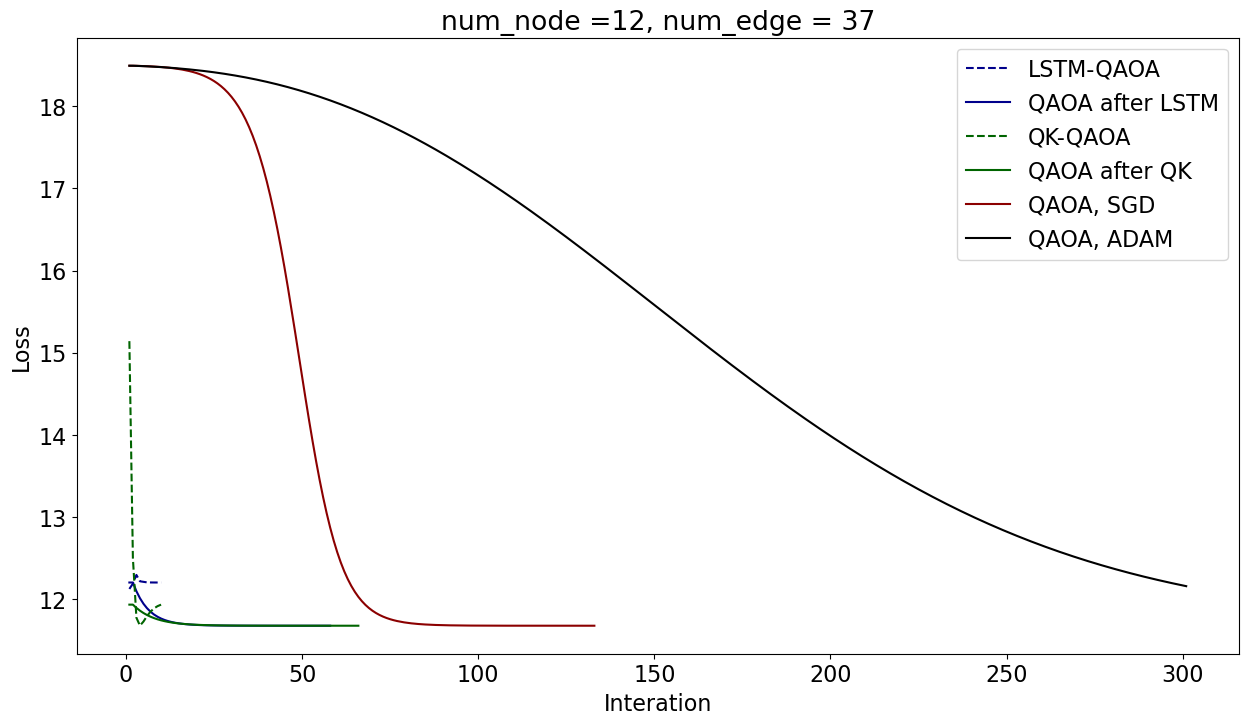

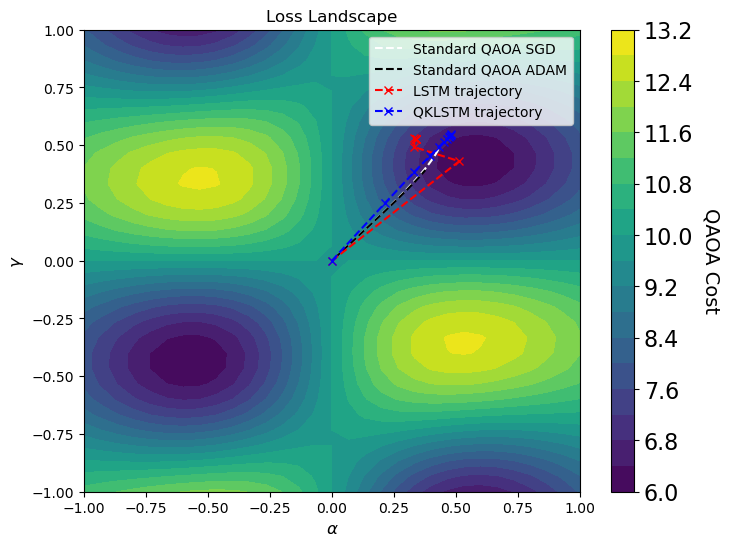


--- Simulation Complete ---


In [175]:
"""
Model Testing
"""
# --- Model Evaluating ---
print(f"\n--- Evaluating Model ---")

#params_rand = torch.rand(input_feature_dim, dtype = torch.float32)
params_rand = torch.tensor([0.01,0.01])

for i in range(len(test_set)):
        graph_test_result = {}
        # predicted by model
        lstm_predicted_params_list, lstm_predicted_energies_list = lstm_trainer.evaluate(
            graph_data = test_set[i],
            num_rnn_iteration = steps_recurrent_loop_test)

        print(f"{lstm_model.model_type} predicted energies:{lstm_predicted_energies_list}")
        print(f"{lstm_model.model_type} predicted params:{lstm_predicted_params_list[-1]}")
       
        # use LSTM/QK -FC output as initial params for QAOA to optimize
        print(f"\n--- QAOA optimization after model ---")
        lstm_qaoa = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  True)
        
        opt_lstm_qaoa = QAOA.QAOAptimizer(lstm_qaoa)
        conv_iter_lstm, final_params_lstm, final_energy_lstm, params_history_lstm, energy_history_lstm = opt_lstm_qaoa.run_optimization(
            initial_params = lstm_predicted_params_list[-1],
            optimizer = qaoa_optimizer,
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        
        # QK
        qk_predicted_params_list, qk_predicted_energies_list = qk_trainer.evaluate(
            graph_data = test_set[i],
            num_rnn_iteration = steps_recurrent_loop_test)

        print(f"{qk_model.model_type} predicted energies:{qk_predicted_energies_list}")
        print(f"{qk_model.model_type} predicted params:{qk_predicted_params_list[-1]}")

        # use LSTM/QK -FC output as initial params for QAOA to optimize
        print(f"\n--- QAOA optimization after model ---")
        qk_qaoa = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  True)
        
        opt_qk_qaoa = QAOA.QAOAptimizer(qk_qaoa)
        conv_iter_qk, final_params_qk, final_energy_qk, params_history_qk, energy_history_qk = opt_qk_qaoa.run_optimization(
            initial_params = qk_predicted_params_list[-1],
            optimizer = qaoa_optimizer,
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        
        # QAOA predict without guess by LSTM/QK
        
        print(f"\n--- Standard QAOA, SGD params ---")
        # random params
        
        qaoa_test_rand = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_rand_qaoa = QAOA.QAOAptimizer(qaoa_test_rand)
        conv_iter_sgd, final_params_sgd, final_energy_sgd, params_history_sgd, energy_history_sgd = opt_rand_qaoa.run_optimization(
            initial_params = params_rand,
            optimizer = "SGD",
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        
        print(f"\n--- Standard QAOA, ADAM params ---")
        # random params
        
        qaoa_test_rand = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_rand_qaoa = QAOA.QAOAptimizer(qaoa_test_rand)
        conv_iter_adam, final_params_adam, final_energy_adam, params_history_adam, energy_history_adam = opt_rand_qaoa.run_optimization(
            initial_params = params_rand,
            optimizer = "ADAM",
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )
        """
        # params which all zeros
        print(f"\n--- Standard VQE, zero params ---")
        params_zeros = torch.zeros(input_feature_dim, dtype = torch.float32)
        qaoa_test_zeros = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_zeros_qaoa = QAOA.QAOAptimizer(qaoa_test_zeros)
        conv_iter_zeros, final_params_zeros, final_energy_zeros, params_history_zeros, energy_history_zeros = opt_zeros_qaoa.run_optimization(
            initial_params = params_zeros,
            optimizer = "SGD",
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa
            )  
        
        print(f"\n--- Standard QAOA, pi params ---")
        params_pi = torch.ones(input_feature_dim,dtype = torch.float32) * math.pi
        qaoa_test_pi = QAOA.QAOA(graph = test_set[i], 
                              n_layers = qaoa_layers, 
                              with_meta =  False)
        
        opt_pi_qaoa = QAOA.QAOAptimizer(qaoa_test_pi)
        conv_iter_pi, final_params_pi, final_energy_pi, params_history_pi, energy_history_pi = opt_pi_qaoa.run_optimization(
            initial_params = params_pi,
            optimizer = qaoa_optimizer,
            max_iter = max_iter_qaoa,
            learning_rate = lr_qaoa,
            conv_tol = conv_tol_qaoa)
        """
        # save result and output as csv
        # result to pd
        graph_test_result = {
            #'molecule': molecule_data.molname,
            #'bondlength': molecule_data.bondlength,
            'LSTM-QAOA': pd.Series(lstm_predicted_energies_list),
            'QAOA after LSTM':pd.Series(energy_history_lstm),
            'QK-QAOA': pd.Series(qk_predicted_energies_list),
            'QAOA after QK': pd.Series(energy_history_qk),
            'QAOA SGD': pd.Series(energy_history_sgd),
            'QAOA ADAM': pd.Series(energy_history_adam),
            #'VQE Zeros': pd.Series(energy_history_zeros),
            #'QAOA Pi': pd.Series(energy_history_pi)
            }
        
        df_result = pd.DataFrame(graph_test_result)
        df_result.to_csv(f"{Results_save_path}_node_{len(test_set[i].nodes)}_edges_{len(test_set[i].edges)}_{i}.csv", index = False)
        print("\n--- Saving Complete ---")
      
        print("Result of QAOA Optimization")
        plt.figure(figsize = (15,8))
        font = {'size':16}
        plt.rc('font', **font)
        plt.plot(range(1, len(lstm_predicted_energies_list) + 1), lstm_predicted_energies_list, label=f'LSTM-QAOA', color = "darkblue", ls="dashed", markersize = 9)
        plt.plot(range(1, len(energy_history_lstm) + 1), energy_history_lstm, label=f'QAOA after LSTM',  color = "darkblue", markersize = 9)
        plt.plot(range(1, len(qk_predicted_energies_list) + 1), qk_predicted_energies_list, label=f'QK-QAOA', ls="dashed", color = "darkgreen", markersize = 9)
        plt.plot(range(1, len(energy_history_qk) + 1), energy_history_qk, label=f'QAOA after QK', color = "darkgreen", markersize = 9)
        plt.plot(range(1, len(energy_history_sgd) + 1), energy_history_sgd, label='QAOA, SGD', color = "darkred", markersize = 9)
        plt.plot(range(1, len(energy_history_adam) + 1), energy_history_adam, label='QAOA, ADAM', color = "black", markersize = 9)
        #plt.plot(range(1, len(energy_history_zeros) + 1), energy_history_zeros, marker='o', label='QAOA, Zeros', ls="dashed")
        #plt.plot(range(1, len(energy_history_pi) + 1), energy_history_pi, marker='o', label='QAOA, Pi', ls="dashed")
        plt.xlabel("Interation")
        plt.ylabel("Loss")
        plt.title(f"num_node ={len(test_set[i].nodes)}, num_edge = {len(test_set[i].edges)}")
        plt.legend()
        #plt.grid(True)
        plt.show()
        
        # LSTM
        params_lstm_x = [0.0]
        params_lstm_y = [0.0]
        for i in range(len(lstm_predicted_params_list)):
             qaoa_params = lstm_predicted_params_list[i].reshape(2,1)
             params_lstm_x.append(qaoa_params[0].item())
             params_lstm_y.append(qaoa_params[1].item())
        # QK
        params_qk_x = [0.0]
        params_qk_y = [0.0]
        for i in range(len(qk_predicted_params_list)):
             qaoa_params = qk_predicted_params_list[i].reshape(2,1)
             params_qk_x.append(qaoa_params[0].item())
             params_qk_y.append(qaoa_params[1].item())
        # standard QAOA random
        params_sgd_x = []
        params_sgd_y = []
        for i in range(len(params_history_sgd)):
             qaoa_params = params_history_sgd[i].reshape(2,1)
             params_sgd_x.append(qaoa_params[0].item())
             params_sgd_y.append(qaoa_params[1].item())

        params_adam_x = []
        params_adam_y = []
        for i in range(len(params_history_adam)):
             qaoa_params = params_history_adam[i].reshape(2,1)
             params_adam_x.append(qaoa_params[0].item())
             params_adam_y.append(qaoa_params[1].item())
        
        landscape_qaoa = QAOA.QAOA(test_set[0], n_layers=1, with_meta = False)
        cost_function = landscape_qaoa.get_loss_function()
        dx = dy = np.linspace(-1, 1, 31)
        dz = np.array([cost_function(torch.tensor([[xx], [yy]], dtype=torch.float32)).numpy() for yy in dy for xx in dx])
        Z = dz.reshape((31, 31))
        plt.figure(figsize = (8,6))
        # Plot cost landscape
        #plt.contourf(dx, dy, Z)
        #plt.colorbar()
        cset = plt.contourf(dx, dy, Z, levels=20) 
        cbar = plt.colorbar(cset)
        cbar.set_label("QAOA Cost", rotation=270, labelpad=20, fontsize=14) 
        # Plot steps
        # standard QAOA
        plt.plot(params_sgd_x, params_sgd_y, linestyle="--", color="white", label = 'Standard QAOA SGD')
        plt.plot(params_adam_x, params_adam_y, linestyle="--", color="black", label = 'Standard QAOA ADAM')
        #plt.plot(params_pi_x, params_pi_y, linestyle="--", color="white", marker="o", label = 'QAOA pi')
        # LSTM
        plt.plot(params_lstm_x, params_lstm_y, linestyle="--", color="red", marker="x", label = 'LSTM trajectory')
        #plt.plot(params_lstm_qaoa_x, params_lstm_qaoa_y, linestyle="--", color="orange", marker="x", label = 'QAOA after LSTM')
        # QK
        plt.plot(params_qk_x, params_qk_y, linestyle="--", color="blue", marker="x", label = 'QKLSTM trajectory')
        #plt.plot(params_qk_qaoa_x, params_qk_qaoa_y, linestyle="--", color="white", marker="x", label = 'QAOA after QK')
        
        plt.yticks(np.linspace(-1, 1, 9))
        plt.xticks(np.linspace(-1, 1, 9))
        plt.xlabel(r"$\alpha$", fontsize=12)
        plt.ylabel(r"$\gamma$", fontsize=12)
        plt.title("Loss Landscape", fontsize=12)
        plt.tick_params(axis='both', which='major', labelsize=10) 
        plt.legend(loc='upper right', frameon = True, fontsize = 10)
        plt.show()


print("\n--- Simulation Complete ---")

## Result

In [69]:
# LSTM
params_lstm_x = [0.0]
params_lstm_y = [0.0]
for i in range(len(lstm_predicted_params_list)):
  qaoa_params = lstm_predicted_params_list[i].reshape(2,1)
  params_lstm_x.append(qaoa_params[0].item())
  params_lstm_y.append(qaoa_params[1].item())

In [70]:
# QK
params_qk_x = [0.0]
params_qk_y = [0.0]
for i in range(len(qk_predicted_params_list)):
  qaoa_params = qk_predicted_params_list[i].reshape(2,1)
  params_qk_x.append(qaoa_params[0].item())
  params_qk_y.append(qaoa_params[1].item())

In [71]:
# standard QAOA random
params_random_x = []
params_random_y = []
for i in range(len(params_history_rand)):
  qaoa_params = params_history_rand[i].reshape(2,1)
  params_random_x.append(qaoa_params[0].item())
  params_random_y.append(qaoa_params[1].item())

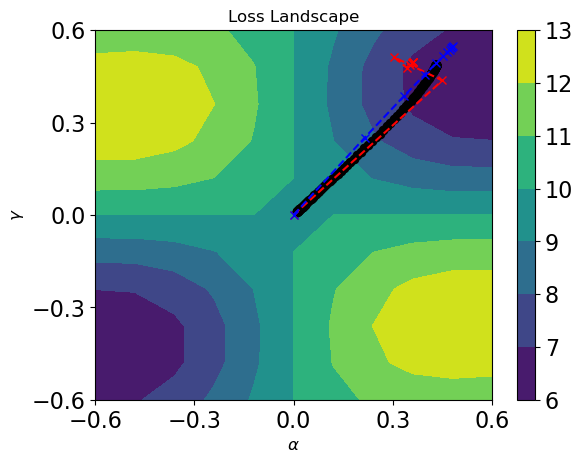

In [77]:
landscape_qaoa = QAOA.QAOA(test_set[0], n_layers=1, with_meta = False)
cost_function = landscape_qaoa.get_loss_function()

dx = dy = np.linspace(-0.6, 0.6, 11)
dz = np.array([cost_function(torch.tensor([[xx], [yy]], dtype=torch.float32)).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11, 11))

# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Plot steps
# standard QAOA
plt.plot(params_random_x, params_random_y, linestyle="--", color="black", marker="o", label = 'QAOA rand')
#plt.plot(params_pi_x, params_pi_y, linestyle="--", color="white", marker="o", label = 'QAOA pi')
# LSTM
plt.plot(params_lstm_x, params_lstm_y, linestyle="--", color="red", marker="x", label = 'LSTM')
#plt.plot(params_lstm_qaoa_x, params_lstm_qaoa_y, linestyle="--", color="orange", marker="x", label = 'QAOA after LSTM')
# QK
plt.plot(params_qk_x, params_qk_y, linestyle="--", color="blue", marker="x", label = 'QK')
#plt.plot(params_qk_qaoa_x, params_qk_qaoa_y, linestyle="--", color="white", marker="x", label = 'QAOA after QK')

plt.yticks(np.linspace(-0.6, 0.6, 5))
plt.xticks(np.linspace(-0.6, 0.6, 5))
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"$\gamma$", fontsize=12)
plt.title("Loss Landscape", fontsize=12)
plt.show()